In [ ]:
#| default_exp harmonic

## Harmonic mapping

> Morph one surface mesh onto another via map to reference shape (disk, sphere). Part of pipeline for dynamic data.

In this notebook, we present some additional wrapping algorithms. So far, we have wrapped two meshes by simply projection each source mesh vertex onto the closest position on the target mesh and carrying out some on-surface smoothing. This works but is not necessarily extremely robust, and can lead to very deformed UV maps when there are large, localized deformations.

Here, we'll implement an alternative algorithm that works by (a) mapping each mesh into a common reference in a mathematically standardized way -[harmonic maps](https://hhoppe.com/mra.pdf)- and then (b) chaining together the map from the source mesh to the common reference and from the reference to the target mesh to get a surface-surface map.

We provide algorithms for meshes of disk, cylindrical, and spherical topology (potentially with holes). For arbitrary genus (i.e. handles, like a torus), one can take a look at hyperbolic orbifolds https://github.com/noamaig/hyperbolic_orbifolds/. Not implemented here.

In [ ]:
#| export

from blender_tissue_cartography import io as tcio
from blender_tissue_cartography import mesh as tcmesh

from blender_tissue_cartography import interpolation as tcinterp
from blender_tissue_cartography import rotation as tcrot
from blender_tissue_cartography import diffgeo as tcdfg

import numpy as np
from copy import deepcopy
import warnings
import igl

from scipy import interpolate, ndimage, optimize, sparse, spatial
from skimage import registration, transform

import matplotlib as mpl

In [ ]:
from blender_tissue_cartography import remesh as tcremesh

from tqdm.notebook import tqdm
from importlib import reload

import matplotlib.pyplot as plt
from scipy import stats

#### Loading test data

Let's load the test meshes from the fly midgut dataset.

In [ ]:
mesh_initial_UV = tcmesh.ObjMesh.read_obj("datasets/movie_example/initial_uv.obj")
mesh_final_UV = tcmesh.ObjMesh.read_obj("datasets/movie_example/final_uv.obj") # this is a UV map defined for tpt 20

mesh_1 = tcmesh.read_other_formats_without_uv(f"datasets/movie_example/meshes/mesh_{str(1).zfill(2)}.ply")
mesh_2 = tcmesh.read_other_formats_without_uv(f"datasets/movie_example/meshes/mesh_{str(2).zfill(2)}.ply")

mesh_60 = tcmesh.read_other_formats_without_uv(f"datasets/movie_example/meshes/mesh_{str(60).zfill(2)}.ply")

  o mesh_01_cylinder_seams_uv
  o mesh_20_uv


## Disk

Following https://libigl.github.io/libigl-python-bindings/tut-chapter4/. We first map each mesh to the unit disk using harmonic coordinates. Boundary conditions are such that the boundary loop is mapped to the unit circle isometrically (i.e. relative distances are preserved).

There is still a remaining rotation degree of freedom. This is fixed by optimizing the match of the conformal factors (i.e. the area distortion of the maps to the disk) using phase correlation.

In [ ]:
#| export

def map_to_disk(mesh, bnd=None, set_uvs=False):
    """
    Map mesh to unit disk by computing harmonic UV coordinates.
    
    The longest boundary loop of the mesh is mapped to the unit circle.
    Follows https://libigl.github.io/libigl-python-bindings/tut-chapter4/.
    Note: the disk is centered at (1/2, 1/2).
    
    The disk rotation angle is arbitrary
    
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    bnd : np.array of ints or None
        Boundary to map to the unit circle. If None, computed automatically.
    set_uvs : bool
        whether to set the disk coordinates as UV coordinates of the mesh.
    
    Returns
    -------
    uv : np.array
        2d vertex coordinates mapping the mesh to the unit disk in [0,1]^1
    
    """
    if not mesh.is_triangular:
        warnings.warn("Warning: ignoring non-triangular faces", RuntimeWarning)
    ## Find the open boundary
    if bnd is None:
        bnd = igl.boundary_loop(mesh.tris)
    assert len(bnd) > 0, "No boundary found! Your mesh may not be a disk" 

    ## Map the boundary to a circle, preserving edge proportions
    bnd_uv = igl.map_vertices_to_circle(mesh.vertices, bnd)

    ## Harmonic parametrization for the internal vertices
    uv = igl.harmonic(mesh.vertices, mesh.tris, bnd, bnd_uv, 1)
    uv = uv/2+np.array([0.5, 0.5])
    
    ## create new mesh
    if set_uvs:
        mesh.faces = [[[v,v] for v in fc] for fc in mesh.tris]
        mesh.texture_vertices = uv
    
    return uv

In [ ]:
mesh = tcmesh.ObjMesh.read_obj("datasets/movie_example/plane_example.obj")

disk_coordinates = map_to_disk(mesh, set_uvs=True)

  o Grid


(-0.049841709467476805,
 1.049992462355594,
 -0.04994346724076043,
 1.0496419841918154)

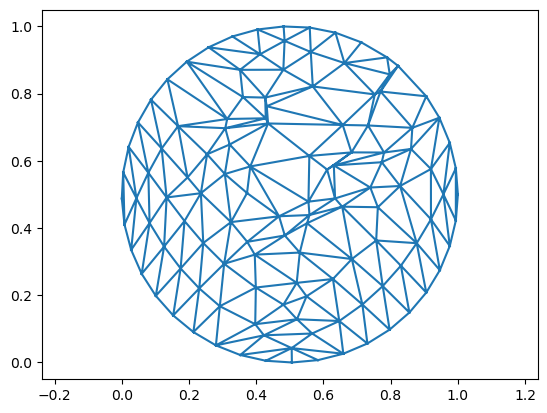

In [ ]:
plt.triplot(*disk_coordinates.T, mesh.tris)
plt.axis("equal")

In [ ]:
igl.flipped_triangles(disk_coordinates, mesh.tris)

array([], shape=(0, 0), dtype=int64)

#### Rotational alignment

The disk can still be rotated freely. Use method from the [Moebius registration paper](https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf):

"We next seek the rotation that best aligns the two parameterizations. To do so, we first sample the conformal factors of each mesh onto a regular spherical grid (Figure 6, top right). We then find the rotation that maximizes the correlation between conformal factors, via a fast spectral transform."

In [ ]:
#| export

def get_rot_mat2d(phi):
    """Get 2d rotation matrix with angle phi."""
    return np.array([[np.cos(phi), np.sin(phi)],[-np.sin(phi), np.cos(phi)]])

In [ ]:
mesh_a = deepcopy(mesh)
mesh_b = deepcopy(mesh)

phi = -0.8*np.pi
mesh_b.texture_vertices = ((mesh_a.texture_vertices-np.array([0.5, 0.5]))@get_rot_mat2d(phi)+np.array([0.5, 0.5]))

# test orientation flip
flip = np.diag([-1,1])
mesh_b.texture_vertices = ((mesh_b.texture_vertices-np.array([0.5, 0.5]))@flip+np.array([0.5, 0.5]))
mesh_b.faces = [fc[::-1] for fc in mesh_b.faces]

(-0.049841709467476805,
 1.049992462355594,
 -0.049963925863437814,
 1.0499208937180065)

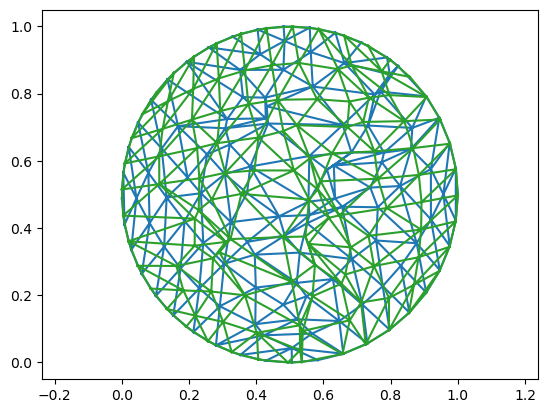

In [ ]:
plt.triplot(*mesh_a.texture_vertices.T, mesh_a.texture_tris)

plt.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris)
plt.axis("equal")

To copy over attributes -like vertex 3d position- from one mesh to another, given a common parametrization, we can use barycentric interpolation.

In [ ]:
#| hide

# find closest points and triangles on target mesh
source_points = np.pad(mesh_a.texture_vertices, ((0,0), (0,1))) 
target_points = np.pad(mesh_b.texture_vertices, ((0,0), (0,1))) 
target_tris = mesh_b.texture_tris

distances, indices, points = igl.point_mesh_squared_distance(source_points, target_points, target_tris)
hit_tris = target_tris[indices]
# barycentric coordinates of the hit points. need small hack for data type issue 
barycentric = igl.barycentric_coordinates_tri(np.array(points, order="C"),
                                             *np.array(target_points[hit_tris].transpose((1,0,2)), order='C'))
# using the barycentric coords we can now interpolate
interpolated = np.einsum('vt,vt...->v...', barycentric, target_points[hit_tris])
# this gives us the same result as going for the closest point directly,
# but now we can also interpolate _other_ attributes
np.allclose(interpolated, points)

True

We compute the remaining degree of freedom - rotations of the unit disk - by aligning the conformal factors of the map to the disk.

In [ ]:
mesh_source, mesh_target = (mesh_a, mesh_b)
q = 0.01
n_grid = 1024 
allow_flip = True

disk_uv_source = np.copy(mesh_source.texture_vertices)
disk_tris_source = mesh_source.texture_tris
disk_uv_target = np.copy(mesh_target.texture_vertices)
disk_tris_target = mesh_target.texture_tris

# compute conformal factors and clip outliers
conformal_factor_source = tcdfg.compute_per_vertex_area_distortion(disk_uv_source, disk_tris_source,
                                                                   mesh_source.vertices, mesh_source.tris)
conformal_factor_source = np.clip(conformal_factor_source, np.quantile(conformal_factor_source, q),
                                  np.quantile(conformal_factor_source, 1-q))
conformal_factor_target = tcdfg.compute_per_vertex_area_distortion(disk_uv_target, disk_tris_target,
                                                                   mesh_target.vertices, mesh_target.tris)
conformal_factor_target = np.clip(conformal_factor_target, np.quantile(conformal_factor_target, q),
                                  np.quantile(conformal_factor_target, 1-q))

# interpolate into UV square
u, v = 2*[np.linspace(0, 1, n_grid),]
UV = np.stack(np.meshgrid(u, v), axis=-1).reshape((-1, 2))
interpolated_source = tcinterp.interpolate_barycentric(UV, disk_uv_source, disk_tris_source,
                                                       conformal_factor_source, distance_threshold=np.inf)
interpolated_source = interpolated_source.reshape((n_grid, n_grid))[::-1]

interpolated_target = tcinterp.interpolate_barycentric(UV, disk_uv_target, disk_tris_target,
                                                       conformal_factor_target, distance_threshold=np.inf)
interpolated_target = interpolated_target.reshape((n_grid, n_grid))[::-1]

# compute rotational alignment
interpolated_source_polar = transform.warp_polar(interpolated_source, radius=n_grid/2-1)
interpolated_target_polar = transform.warp_polar(interpolated_target, radius=n_grid/2-1)
shifts, error, _ = registration.phase_cross_correlation(interpolated_source_polar, interpolated_target_polar,
                                                        normalization=None)
if allow_flip:
    interpolated_source_polar_flipped = interpolated_source_polar[::-1]
    shifts_flipped, error_flipped, _ = registration.phase_cross_correlation(interpolated_source_polar_flipped,
                                                    interpolated_target_polar,
                                                    normalization=None)
    if error > error_flipped:
        rot_angle = shifts_flipped[0]*np.pi/180
        rot_mat = -get_rot_mat2d(rot_angle)
        new_texture_vertices = (disk_uv_source-np.array([0.5,0.5]))@rot_mat.T
        new_texture_vertices += np.array([0.5,0.5])
    
rot_angle = shifts[0]*np.pi/180
rot_mat = get_rot_mat2d(rot_angle)
new_texture_vertices = (disk_uv_source-np.array([0.5,0.5]))@rot_mat.T
new_texture_vertices += np.array([0.5,0.5])

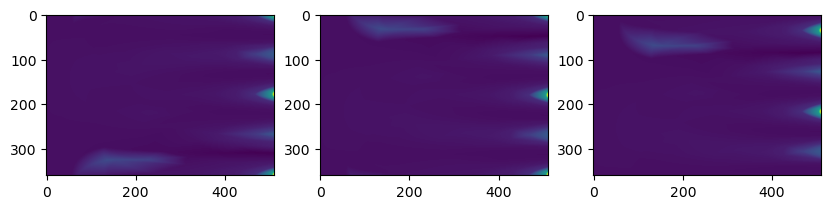

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,5), ncols=3)
ax1.imshow(interpolated_source_polar)
ax2.imshow(interpolated_source_polar_flipped)
ax3.imshow(interpolated_target_polar)

print()

In [ ]:
#| export

def rotational_align_disk(mesh_source, mesh_target, disk_uv_source=None, disk_uv_target=None,
                          allow_flip=True, q=0.01, n_grid=1024):
    """
    Rotationally align two UV maps to the disk by the conformal factor.
    
    Computes aligned UV coordinates. Assumes that the UV
    coordinates are in [0,1]^2. This works by computing
    the conformal factor (how much triangle size changes as it is
    mapped to the plane, and finding the optimal rotation to align
    the conformal factors via phase correlation.
    
    Parameters
    ----------
    mesh_source : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    mesh_target : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    disk_uv_source : np.array or None
        Disk coordinates for each vertex in the source mesh. Optional.
        If None, the UV coordinates of mesh_source are used.
    disk_uv_target : np.array or None
        Disk coordinates for each vertex in the target mesh. Optional.
        If None, the UV coordinates of disk_uv_target are used.
    allow_flip : bool
        Whether to allow flips (improper rotations). If a flip
        occurs, np.linalg.det(rot_mat) < 0
    q : float between 0 and 0.5
        Conformal factors are clipped at this quantile to avoid outliers.
    n_grid : int
        Grid for interpolation of conformal factor during alignment
    
    Returns
    -------
    new_texture_vertices_mesh_source : np.array
        Rotationally aligned texture vertices
    rot_mat : np.array of shape (2,2)
        Rotation matrix
    overlap : float
        Overlap between aligned conformal factors. 1 = perfect alignment.
    
    """
    if disk_uv_source is None:
        disk_uv_source = np.copy(mesh_source.texture_vertices)
        disk_tris_source = mesh_source.texture_tris
    else:
        disk_tris_source = mesh_source.tris
    if disk_uv_target is None:
        disk_uv_target = np.copy(mesh_target.texture_vertices)
        disk_tris_target = mesh_target.texture_tris
    else:
        disk_tris_target = mesh_target.tris
    # compute conformal distortion factors, clip to avoid outliers
    conformal_factor_source = tcdfg.compute_per_vertex_area_distortion(disk_uv_source, disk_tris_source,
                                                                       mesh_source.vertices, mesh_source.tris,)
    conformal_factor_source = np.clip(conformal_factor_source, np.quantile(conformal_factor_source, q),
                                      np.quantile(conformal_factor_source, 1-q))
    conformal_factor_target = tcdfg.compute_per_vertex_area_distortion(disk_uv_target, disk_tris_target,
                                                                       mesh_target.vertices, mesh_target.tris)
    conformal_factor_target = np.clip(conformal_factor_target, np.quantile(conformal_factor_target, q),
                                      np.quantile(conformal_factor_target, 1-q))
    assert conformal_factor_source.mean() > 0, "Maps to disk must be orientation-preserving"
    assert conformal_factor_target.mean() > 0, "Maps to disk must be orientation-preserving"
    # interpolate into UV square
    u, v = 2*[np.linspace(0, 1, n_grid),]
    UV = np.stack(np.meshgrid(u, v), axis=-1).reshape((-1, 2))
    interpolated_source = tcinterp.interpolate_barycentric(UV, disk_uv_source, disk_tris_source,
                                                           conformal_factor_source, distance_threshold=np.inf)
    interpolated_source = interpolated_source.reshape((n_grid, n_grid))[::-1]

    interpolated_target = tcinterp.interpolate_barycentric(UV, disk_uv_target, disk_tris_target,
                                                           conformal_factor_target, distance_threshold=np.inf)
    interpolated_target = interpolated_target.reshape((n_grid, n_grid))[::-1]
    # compute rotational alignment, allowing for flips
    interpolated_source_polar = transform.warp_polar(interpolated_source, radius=n_grid/2-1)
    interpolated_target_polar = transform.warp_polar(interpolated_target, radius=n_grid/2-1)
    shifts, error, _ = registration.phase_cross_correlation(interpolated_source_polar, interpolated_target_polar,
                                                            normalization=None)
    if allow_flip:
        interpolated_source_polar_flipped = interpolated_source_polar[::-1]
        shifts_flipped, error_flipped, _ = registration.phase_cross_correlation(interpolated_source_polar_flipped,
                                                        interpolated_target_polar, normalization=None)
        if error > error_flipped:
            rot_angle = -shifts_flipped[0]*np.pi/180
            rot_mat = get_rot_mat2d(rot_angle) @ np.diag([1,-1])
            new_texture_vertices = (disk_uv_source-np.array([0.5,0.5]))@rot_mat.T
            new_texture_vertices += np.array([0.5,0.5])
            return new_texture_vertices, rot_mat, 1-error_flipped
    rot_angle = -shifts[0]*np.pi/180
    rot_mat = get_rot_mat2d(rot_angle)
    new_texture_vertices = (disk_uv_source-np.array([0.5,0.5]))@rot_mat.T
    new_texture_vertices += np.array([0.5,0.5])
    return new_texture_vertices, rot_mat, 1-error

In [ ]:
mesh_a = deepcopy(mesh)
mesh_b = deepcopy(mesh)

phi = -0.8*np.pi
mesh_b.texture_vertices = ((mesh_a.texture_vertices-np.array([0.5, 0.5]))@get_rot_mat2d(phi)+np.array([0.5, 0.5]))

flip = np.diag([-1,1])
mesh_b.texture_vertices = ((mesh_b.texture_vertices-np.array([0.5, 0.5]))@flip+np.array([0.5, 0.5]))
mesh_b.faces = [fc[::-1] for fc in mesh_b.faces]

In [ ]:
new_vertices, rot_mat, overlap = rotational_align_disk(mesh_a, mesh_b, allow_flip=True)

overlap

0.9995530944863507

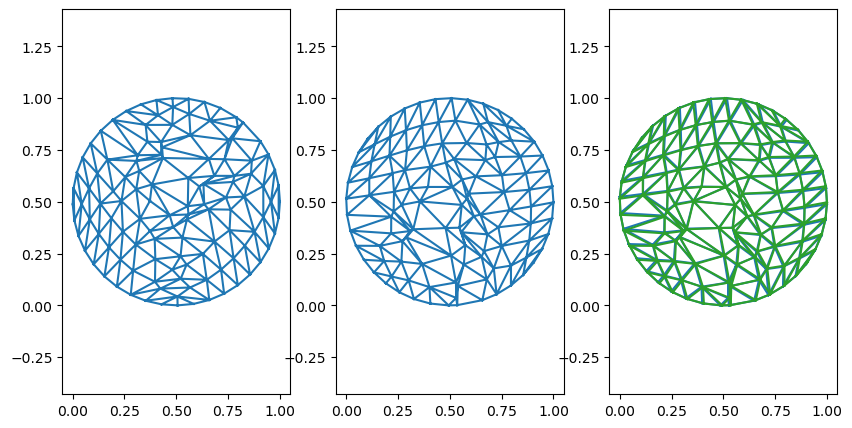

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10,5), ncols=3)
ax1.triplot(*mesh_a.texture_vertices.T, mesh_a.texture_tris)
ax2.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris)
ax3.triplot(*new_vertices.T, mesh_b.texture_tris)
ax3.triplot(*mesh_b.texture_vertices.T, mesh_b.texture_tris)


for ax in [ax1, ax2, ax3]:
    ax.axis("equal")

### Mesh registration


In [ ]:
#| export

def wrap_coords_via_disk(mesh_source, mesh_target,
                         disk_uv_source=None, disk_uv_target=None,
                         align=True, q=0.01, n_grid=1024):
    """
    Map 3d coordinates of source mesh to target mesh via a disk parametrization.
    
    Disk parametrization can be provided or computed on the fly via harmonic coordinates.
    If desired, the two disks are also rotationally aligned.
    
    Parameters
    ----------
    mesh_source : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    mesh_target : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    disk_uv_source : np.array or None
        Disk coordinates for each vertex in the source mesh. Optional.
        If None, computed via map_to_disk.
    disk_uv_target : np.array or None
        Disk coordinates for each vertex in target mesh. Optional.
        If None, computed via map_to_disk.
    align : bool, default True
        Whether to rotationally align the parametrizations. If False, they are used as-is.
    q : float between 0 and 0.5
        Conformal factors are clipped at this quantile to avoid outliers.
    n_grid : int
        Grid for interpolation of conformal factor during alignment.
        Higher values increase alignment precision.
    
    Returns
    -------
    new_coords : np.array
        New 3d vertex coordinates for mesh_source, lying on the surface
        defined by mesh_target
    overlap : float
        Only returned if align is True. A measure of geometry overlap. 1 = perfect alignment
    """
    # compute harmonic map to disk
    if disk_uv_source is None:
        disk_uv_source = map_to_disk(mesh_source, set_uvs=False)
    if disk_uv_target is None:
        disk_uv_target = map_to_disk(mesh_target, set_uvs=False)
    # rotational alignment of parametrizations
    if align:
        disk_uv_source_aligned, _, _ = rotational_align_disk(mesh_source, mesh_target, disk_uv_source, disk_uv_target,
                                                             q=q, n_grid=n_grid)
    else:
        disk_uv_source_aligned = disk_uv_source
    # copy over 3d coordinates 
    new_coords = tcinterp.interpolate_barycentric(np.pad(disk_uv_source_aligned, ((0,0), (0,1))),
                                                  np.pad(disk_uv_target, ((0,0), (0,1))),
                                                  mesh_target.tris, mesh_target.vertices, distance_threshold=np.inf)
    if align:
        return new_coords, overlap
    return new_coords

In [ ]:
mesh_source = tcmesh.ObjMesh.read_obj("datasets/movie_example/plane_example.obj")
mesh_target = deepcopy(mesh_source)

random_rot = stats.special_ortho_group.rvs(3)
mesh_target.vertices = mesh_target.vertices@random_rot + np.array([2, 9, 1])

  o Grid


In [ ]:
mesh_source = tcmesh.ObjMesh.read_obj("datasets/movie_example/plane_example.obj")
mesh_target = deepcopy(mesh_source)

random_rot = stats.special_ortho_group.rvs(3)
mesh_target.vertices = mesh_target.vertices@random_rot + np.array([2, 9, 1])

  o Grid


In [ ]:
new_coords, overlap = wrap_coords_via_disk(mesh_source, mesh_target)

In [ ]:
np.linalg.norm(new_coords-mesh_target.vertices, axis=-1).mean()

1.3403645763230948e-15

### Cylindrical topology

Map a cylinder to the disk: fill one boundary with an extra vertex, map to the disk harmonically, use Moebius to move the extra vertex to the disk center.

In [ ]:
#| export

def polygon_area(pts):
    """ Polygon area via shoe-lace formula. Assuming no self-intersection. pts.shape is (..., 2)"""
    return np.sum(pts[...,0]*np.roll(pts[...,1], 1, axis=0) - np.roll(pts[...,0], 1, axis=0)*pts[...,1], axis=0)/2

def polygon_centroid(pts):
    """See https://en.wikipedia.org/wiki/Centroid. pts.shape is (..., 2)"""
    C_x = np.sum((pts[...,0]+np.roll(pts[...,0], 1, axis=0))
                 *(pts[...,0]*np.roll(pts[...,1], 1, axis=0)-np.roll(pts[...,0], 1, axis=0)*pts[...,1]), axis=0)/2
    C_y = np.sum((pts[...,1]+np.roll(pts[...,1], 1, axis=0))
                 *(pts[...,0]*np.roll(pts[...,1], 1, axis=0)-np.roll(pts[...,0], 1, axis=0)*pts[...,1]), axis=0)/2
    return np.array([C_x, C_y]) / (6*polygon_area(pts))

def xy_to_complex(arr):
    """Map (x,y) to x+iy. arr.shape==(...,2 )"""
    return arr[...,0]+1j*arr[...,1]

def complex_to_xy(arr):
    """Map x+iy to (x, y). Return shape==(...,2 )"""
    return np.stack([arr.real, arr.imag], axis=-1)

def moebius_disk(pts, b):
    """Compute a Moebius transformation of the disk. Moves disk origin by b. pts.shape is (..., 2)"""
    z, b = (xy_to_complex(pts), xy_to_complex(b))
    z_transformed = (z+b)/(1+np.conjugate(b)*z)
    return complex_to_xy(z_transformed)

In [ ]:
#mesh = tcmesh.ObjMesh.read_obj("movie_example/cylinder.obj") # cylinder_clean

#mesh = tcmesh.ObjMesh.read_obj("movie_example/mesh_1_cylinder_cut.obj") # cylinder_clean
mesh = tcmesh.ObjMesh.read_obj("datasets/movie_example/mesh_1_cylinder_cut_non_centered.obj") # cylinder_clean

  o mesh_01


In [ ]:
# determine the boundary 
first_boundary = igl.boundary_loop(mesh.tris)
all_boundary_edges = igl.boundary_facets(mesh.tris)
second_boundary = igl.edges_to_path(np.stack([e for e in all_boundary_edges if not e[0] in first_boundary]))[0][:-1]

In [ ]:
# add an extra vertex and triangles
filled_tris = igl.topological_hole_fill(mesh.tris, [second_boundary])
center_second_boundary = mesh.vertices[second_boundary].mean(axis=0)
filled_vertices = np.vstack([mesh.vertices, [center_second_boundary]])

In [ ]:
filled_vertices.shape[0], mesh.vertices.shape[0], filled_tris.shape[0]-mesh.tris.shape[0], second_boundary.shape[0]

(20002, 20001, 16, 16)

In [ ]:
# check - looks good
mesh_filled = tcmesh.ObjMesh(vertices=filled_vertices, faces=filled_tris)
mesh_filled.write_obj("datasets/movie_example/mesh_1_cylinder_cut_non_centered_filled.obj") # cylinder_clean

In [ ]:
# map to disk via harmonic map

bnd_uv = 1 * igl.map_vertices_to_circle(filled_vertices, first_boundary)
uv = igl.harmonic(filled_vertices, filled_tris, first_boundary, bnd_uv, 1)
# map the center of the second boundary to disk center
uv = moebius_disk(uv, -uv[-1])

In [ ]:
uv[-1] # last point -at the center of filled cylinder opening- is mapped to center of 

array([0., 0.])

(-1.096551335368751,
 1.0954288401027532,
 -1.0993918966333553,
 1.0999552780113782)

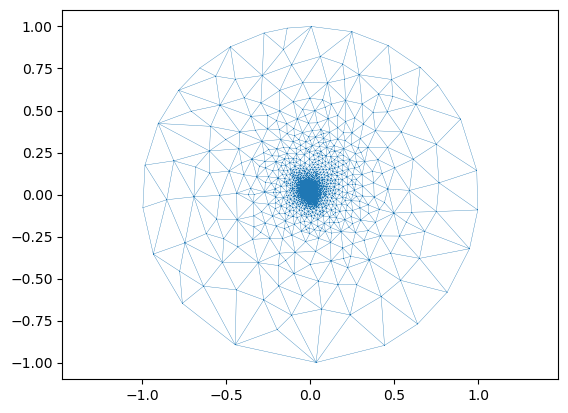

In [ ]:
plt.triplot(*uv.T, filled_tris, lw=0.25)
plt.axis("equal")

In [ ]:
#| hide
#| notest

# try to do map the inner boundary to a fixed radius - no good.

R_inner = 0.01

uv_outer = uv[first_boundary]
uv_inner = uv[second_boundary]
uv_inner = R_inner*(uv_inner.T / np.linalg.norm(uv_inner, axis=1)).T

# deform to match
success, uv_fixed = igl.bijective_composite_harmonic_mapping(uv, filled_tris,
                                                             np.hstack([first_boundary, second_boundary]),
                                                             np.vstack([uv_outer, uv_inner]))


In [ ]:
#| export

def map_cylinder_to_disk(mesh, outer_boundary="longest", first_boundary=None,
                         second_boundary=None, set_uvs=False, return_filled=False):
    """
    Map cylinder mesh to unit disk by computing harmonic UV coordinates.
    
    One boundary loop of the mesh is mapped to the circle with a diameter 1/2.
    The second boundary is filled by adding an extra vertex at its center,
    which is mapped to the disk center.  
    
    Which of the two circular boundaries is mapped to the center resp.
    the outer circle is set by the option outer_boundary.
    
    The disk rotation angle is arbitrary.
    
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    outer_boundary : "longest", "shortest" or int
        Boundary to map to the unit circle. If "longest"/"shortest", 
        the longer/shorter one is mapped to the unit circle. If int,
        the boundary containing the vertex defined by the int is used.
    first_boundary : np.array of ints or None
        First boundary loop of cylinder. If None, computed automatically.
    second_boundary : np.array of ints or None
        Second boundary loop of cylinder. If None, computed automatically.
    set_uvs : bool
        whether to set the disk coordinates as UV coordinates of the mesh.
    return_filled : bool
        Whether to return vertices and faces with filled hole.
    
    Returns
    -------
    uv : np.array
        2d vertex coordinates mapping the mesh to the unit disk in [0,1]^1.
        If filled_vertices is True, the last entry is the coordinate of the added point.
    filled_vertices : np.array
        3d vertices with extra vertex to fill second boundary
    filled_faces : np.array
        Faces with added faces to fill the second boundary.
    
    """
    if not mesh.is_triangular:
        warnings.warn("Warning: ignoring non-triangular faces", RuntimeWarning)
    # determine the boundary
    if first_boundary is None:
        first_boundary = igl.boundary_loop(mesh.tris)
    if second_boundary is None:
        all_boundary_edges = igl.boundary_facets(mesh.tris)
        second_boundary = igl.edges_to_path(np.stack([e for e in all_boundary_edges
                                                      if not e[0] in first_boundary]))[0][:-1]    
    assert len(first_boundary) > 0 and len(second_boundary) > 0, "No boundary found! Your mesh must be a cylinder" 
    # decide which one is the outer boundary
    if outer_boundary == "shortest" or outer_boundary in second_boundary:
        first_boundary, second_boundary = (second_boundary, first_boundary)
    # add an extra vertex and triangles
    filled_tris = igl.topological_hole_fill(mesh.tris, [second_boundary])
    center_second_boundary = mesh.vertices[second_boundary].mean(axis=0)
    filled_vertices = np.vstack([mesh.vertices, [center_second_boundary]])    # map to disk via harmonic map
    bnd_uv = igl.map_vertices_to_circle(filled_vertices, first_boundary)
    uv = igl.harmonic(filled_vertices, filled_tris, first_boundary, bnd_uv, 1)
    # map the center of the second boundary to disk center
    uv = moebius_disk(uv, -uv[-1])
    # translate+scale so we fit in the UV square
    uv = uv/2+np.array([0.5, 0.5])
    # set UV coordinates if desired mesh
    if set_uvs:
        mesh.faces = [[[v,v] for v in fc] for fc in mesh.tris]
        mesh.texture_vertices = uv[:-1]
    if return_filled:
        return uv, filled_vertices, filled_tris
    return uv[:-1]

In [ ]:
mesh = tcmesh.ObjMesh.read_obj("datasets/movie_example/cylinder.obj") # cylinder_clean

In [ ]:
uv = map_cylinder_to_disk(mesh, outer_boundary="longest")

In [ ]:
igl.flipped_triangles(uv, mesh.tris)

array([], shape=(0, 0), dtype=int64)

(-0.049183316665476866,
 1.049654650031695,
 -0.04980286502601551,
 1.0499106507897504)

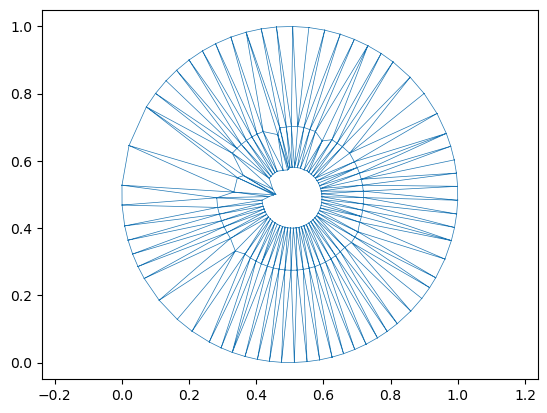

In [ ]:
plt.triplot(*uv.T, mesh.tris, lw=0.5)
plt.axis("equal")

In [ ]:
## let's try a more challenging example - midgut mesh with two cuts to make it a cylinder

mesh = tcmesh.ObjMesh.read_obj("datasets/movie_example/mesh_1_cylinder_cut.obj") # cylinder_clean

  o mesh_01


In [ ]:
uv = map_cylinder_to_disk(mesh, outer_boundary="longest",)
uv_reverse = map_cylinder_to_disk(mesh, outer_boundary="shortest", )

(-0.04881346336073662,
 1.0499255590960166,
 -0.049218476987450965,
 1.0493085140972238)

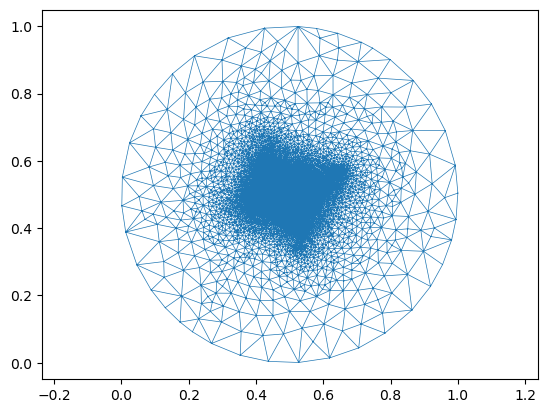

In [ ]:
plt.triplot(*uv.T, mesh.tris, lw=0.5)
plt.axis("equal")

(-0.04834689694663298,
 1.047823750534748,
 -0.04965982618548542,
 1.0499708292802348)

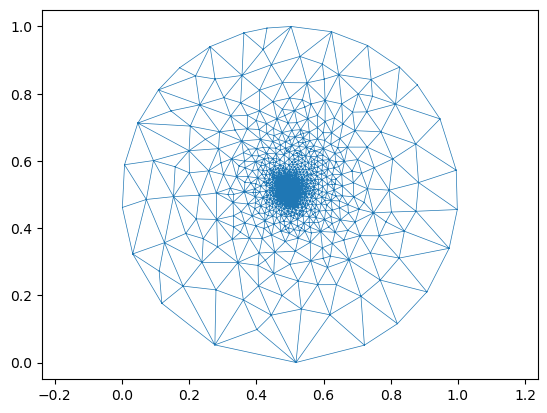

In [ ]:
plt.triplot(*uv_reverse.T, mesh.tris, lw=0.5)
plt.axis("equal")

In [ ]:
#| export

def wrap_coords_via_disk_cylinder(mesh_source, mesh_target, q=0.01, n_grid=1024):
    """
    Map 3d coordinates of source mesh to target mesh via an annulus parametrization.
    
    Annulus parametrization can be provided or computed on the fly via harmonic coordinates.
    If desired, the two disks are also rotationally aligned. Meshes must be cylindrical.
    Two choices exist for mapping a cylinder to the plane (depending on which boundary
    circle is mapped to the disk boundary resp. center). Both options are tried,
    and the one leading to better alignment is used.
    
    If you already have a map to the disk, use wrap_coords_via_disk instead.
    
    Parameters
    ----------
    mesh_source : tcmesh.ObjMesh
        Mesh. Must be topologically a cylinder and should be triangular.
    mesh_target : tcmesh.ObjMesh
        Mesh. Must be topologically a cylinder and should be triangular.
    q : float between 0 and 0.5
        Conformal factors are clipped at this quantile to avoid outliers.
    n_grid : int
        Grid for interpolation of conformal factor during alignment.
        Higher values increase alignment precision.
    
    Returns
    -------
    new_coords : np.array
        New 3d vertex coordinates for mesh_source, lying on the surface
        defined by mesh_target
    overlap : float
        Measure of geometry overlap. 1 = perfect alignment
    """
    # compute harmonic map to annulus. For the source mesh, try both cylinders
    disk_uv_source_a = map_cylinder_to_disk(mesh_source, outer_boundary="longest",
                                            return_filled=False, set_uvs=False,)
    disk_uv_source_b = map_cylinder_to_disk(mesh_source, outer_boundary="shortest",
                                            return_filled=False, set_uvs=False,)
    disk_uv_target, vertices_target_filled, faces_target_filled = map_cylinder_to_disk(mesh_target, set_uvs=False,
                                                                                       outer_boundary="longest",
                                                                                       return_filled=True)
    # rotational alignment of parametrizations
    disk_uv_source_aligned_a, _, overlap_a = rotational_align_disk(mesh_source, mesh_target,
                                                                   disk_uv_source_a, disk_uv_target[:-1], 
                                                                   q=q, n_grid=n_grid)
    disk_uv_source_aligned_b, _, overlap_b = rotational_align_disk(mesh_source, mesh_target,
                                                                   disk_uv_source_b, disk_uv_target[:-1],
                                                                   q=q, n_grid=n_grid)
    if overlap_a > overlap_b:
        disk_uv_source_aligned = disk_uv_source_aligned_a
        overlap = overlap_a
    else:
        disk_uv_source_aligned = disk_uv_source_aligned_b
        overlap = overlap_b
    # copy over 3d coordinates. use filled topology
    disk_uv_target_filled = np.vstack([disk_uv_target, [np.array([0.5, 0.5])]])
    new_coords = tcinterp.interpolate_barycentric(np.pad(disk_uv_source_aligned, ((0,0), (0,1))),
                                                  np.pad(disk_uv_target_filled, ((0,0), (0,1))),
                                                  faces_target_filled, vertices_target_filled,
                                                  distance_threshold=np.inf)
    return new_coords, overlap

In [ ]:
mesh_source = tcmesh.ObjMesh.read_obj("datasets/movie_example/mesh_1_cylinder_cut.obj") # cylinder_clean
mesh_target = tcmesh.ObjMesh.read_obj("datasets/movie_example/mesh_1_cylinder_cut_non_centered.obj") # cylinder_clean

  o mesh_01
  o mesh_01


In [ ]:
new_coords, overlap = wrap_coords_via_disk_cylinder(mesh_source, mesh_target,
                                                    q=0.01, n_grid=1024)

In [ ]:
mesh_wraped = tcmesh.ObjMesh(vertices=new_coords, faces=mesh_source.faces, texture_vertices=None)
mesh_wraped.write_obj("datasets/movie_example/mesh_1_cylinder_cut_wrapepd.obj")

## Sphere

For the sphere, we follow https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf. The Riemann mapping theorem guarantees there is a conformal map of our surface to the unit sphere. This map is unique up to Moebius transformations (inversion about a point in the unit ball, and rotations). We fix the inversions by choosing the conformal map with the least amount of area distortion, and the rotation by registering the conformal factors as functions on the unit sphere using spherical harmonics

- Cut sphere to disk by removing a single vertex
- Map disk to plane conformally using harmonic coordinates. Turns out the least-squares conformal map is lousy at preserving angles (at least in `igl`)
- Map disk to a sphere using stereographic projection, adding the removed vertex at the north pole
- Fix Moebius inversion by choosing a conformal map with minimal distortion using Algorithm 1 from https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf
- Rotational registration using spherical harmonics (see notebook 03c)
- Interpolation of vertex positions using spherical parametrization

In [ ]:
mesh = deepcopy(mesh_final_UV)

In [ ]:
#| hide

## Let's test this before computing the full map

# remove "north pole" - by convention, the last vertex in the mesh
north_pole = mesh.vertices.shape[0]-1
tri_mask = (mesh.tris==north_pole).any(axis=1) 
faces_disk = mesh.tris[~tri_mask]
vertices_disk = mesh.vertices[:-1]
## Find the open boundary
bnd = igl.boundary_loop(faces_disk)

## harmonic map
bnd_uv = igl.map_vertices_to_circle(vertices_disk, bnd)
#bnd_uv = np.array([[np.sin(i*2*np.pi/bnd.shape[0]), np.cos(i*2*np.pi/bnd.shape[0])] for i in range(bnd.shape[0])])
uv = igl.harmonic(vertices_disk, faces_disk, bnd, bnd_uv, 1)

[<matplotlib.lines.Line2D>,
 <matplotlib.lines.Line2D>]

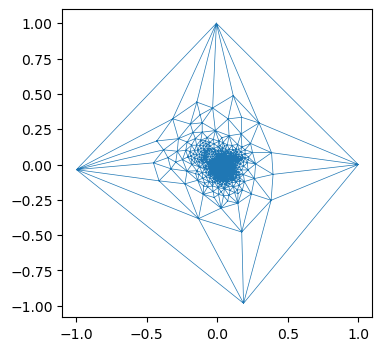

In [ ]:
# this is what the map of the mesh sans north pole to the plane looks like

fig = plt.figure(figsize=(4,4))

plt.triplot(*uv.T, faces_disk, lw=0.5)

In [ ]:
#| hide

(igl.doublearea(uv, faces_disk) <= 0).mean() # no negative areas - good

0.0

In [ ]:
#| hide

angles_3d = igl.internal_angles(vertices_disk, faces_disk)
angles_uv = igl.internal_angles(uv, faces_disk)
np.nanmean(np.abs(angles_3d-angles_uv)/(np.pi/3)) # angles in 3d / 2d are closely correlated

0.06022943210754354

In [ ]:
#| hide

@tcio.deprecated
def find_conformal_boundary_conditions(vertices_disk, faces_disk, bnd, tol=1e-2):
    """
    Find boundary conditions for a map to disk most compatible with a conformal map.
    
    Uses a stupid method - direct optimization. Not to be used beyond beyond boundaries 
    more than a few vertices long.
    
    To do: look at https://arxiv.org/pdf/1704.06873
    """
    angles_3d = igl.internal_angles(vertices_disk, faces_disk)
    bnd_uv_initial = igl.map_vertices_to_circle(vertices_disk, bnd)
    phi_bnd_initial = np.arctan2(*bnd_uv_initial.T)
    def _conformal_err(phi_bnd):
        bnd_uv = np.stack([np.sin(phi_bnd), np.cos(phi_bnd)], axis=-1)
        uv = igl.harmonic(vertices_disk, faces_disk, bnd, bnd_uv, 1)
        angles_uv = igl.internal_angles(uv, faces_disk)
        return np.nanmean(np.abs(angles_3d-angles_uv))

    sol = optimize.minimize(_conformal_err, phi_bnd_initial, method="BFGS", tol=tol,
                           options={"maxiter": 100})
    bnd_final = np.stack([np.sin(sol.x), np.cos(sol.x)], axis=-1)
    return bnd_final

In [ ]:
#| hide
#| notest

bnd_final = find_conformal_boundary_conditions(vertices_disk, faces_disk, bnd)
uv = igl.harmonic(vertices_disk, faces_disk, bnd, bnd_final, 1)

<timed exec>:1: DeprecationWarning: Call to deprecated function find_conformal_boundary_conditions.


CPU times: user 6.51 s, sys: 175 ms, total: 6.68 s
Wall time: 6.32 s


In [ ]:
#| hide
#| notest

angles_3d = igl.internal_angles(mesh.vertices, mesh.tris)
angles_uv = igl.internal_angles(uv, mesh.tris)
np.corrcoef(angles_uv.flatten(), angles_3d.flatten())[0, 1], np.mean(np.abs(angles_3d-angles_uv))

### Strereographic projection

In [ ]:
#| export

def stereographic_plane_to_sphere(uv):
    """
    Stereographic projection from plane to the unit sphere from the north pole (0,0,1).
    
    See https://en.wikipedia.org/wiki/Stereographic_projection.
    Convention: plane is at z=0, unit sphere centered at origin.
    uv should be an array of shape (..., 2)
    """
    return (np.stack([2*uv[:,0], 2*uv[:,1], uv[:,0]**2+uv[:,1]**2-1], axis=0) / (1+uv[:,0]**2+uv[:,1]**2)).T
    
def stereographic_sphere_to_plane(pts):
    """
    Stereographic projection from unit sphere to plane from the north pole (0,0,1).
    
    See https://en.wikipedia.org/wiki/Stereographic_projection.
    Convention: the plane is at z=0, unit sphere centered at the origin.
    pts should be an array of shape (..., 3)
    """
    assert np.allclose(np.linalg.norm(pts, axis=1), 1, rtol=1e-03, atol=1e-04), "Points not on unit sphere!"
    return (np.stack([pts[:,0], pts[:,1]], axis=0)/(1-pts[:,2])).T

In [ ]:
(np.allclose(np.linalg.norm(stereographic_plane_to_sphere(uv), axis=1), 1),
 np.allclose(stereographic_sphere_to_plane(stereographic_plane_to_sphere(uv)), uv))

(True, True)

### Moebius centering algorithm

Algorithm 1 from https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf

In [ ]:
#| export

def center_moebius(vertices_3d, vertices_sphere, tris, n_iter_centering=10, alpha=0.5):
    """
    Apply Moeboius inversions to minimize area distortion of a map from mesh to sphere.
    
    Implementation of Algorithm 1 from:
    https://www.cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf
    
    Parameters
    ----------
    vertices_3d : np.array of shape (n_verts, 3)
        3d mesh vertices
    vertices_sphere : np.array of shape (n_verts, 3)
        Initial vertex positions on unit sphere
    tris : np.array of shape (n_faces, 3) and type int
        Faces of a triangular mesh
    n_iter_centering : int
        Centering algorithm iterations.
    alpha : float between 0 and 1
        Learning rate. Lower values make the algorithm more stable
    
    Returns
    -------
    vertices_sphere_centered : np.array of shape (n_verts, 3)
        Centered sphere coordinates
    com_norm : float
        Distance of sphere vertex center of mass from origin. Low values
        indicate convergence of the algorithm.
    """
    As = igl.doublearea(vertices_3d, tris)
    As /= As.sum()
    Vs = np.copy(vertices_sphere)
    for i in range(n_iter_centering):
        # compute triangle centroids
        Cs = Vs[tris].mean(axis=1)
        Cs = (Cs.T/np.linalg.norm(Cs,axis=-1)).T
        # compute center of mass, weighted by 3d areas
        mu = (As*Cs.T).sum(axis=1)
        # compute Jacobian and get inversion center
        J = (As*(np.eye(3) - np.einsum('vi,vj->vij', Cs, Cs)).T).sum(axis=-1)
        c = -alpha*np.linalg.inv(J)@mu
        # compute inversion
        Vs = ((1-np.linalg.norm(c)**2)*(Vs+c).T /np.linalg.norm(Vs+c, axis=1)**2).T + c
    return Vs, np.linalg.norm(mu)

### Putting it all together ...

In [ ]:
#| hide
#| notest

mesh = deepcopy(mesh_final_UV)
method = "harmonic"

# remove "north pole" - by convention, the last vertex in the mesh
north_pole = mesh.vertices.shape[0]-1
faces_all = mesh.tris
tri_mask = (faces_all==north_pole).any(axis=1) 
faces_disk = faces_all[~tri_mask]
vertices_disk = mesh.vertices[:-1]
## Find the open boundary
bnd = igl.boundary_loop(faces_disk)
assert method in ["LSCM", "harmonic"], "Method must be LSCM or harmonic"
if method == "LSCM": ## least squares conformal map
    bnd = igl.boundary_loop(faces_disk)
    b = np.array([bnd[0], bnd[int(np.round(len(bnd)/2))]])
    bc = np.array([[0.0, -1.0], [0.0, 1.0]])
    _, uv = igl.lscm(vertices_disk, faces_disk, b, bc)
    uv = uv-uv.mean(axis=0)
if method == "harmonic": # harmonic map
    bnd_uv = igl.map_vertices_to_circle(vertices_disk, bnd)
    uv = igl.harmonic(vertices_disk, faces_disk, bnd, bnd_uv, 1)


(-1.0993061541722389,
 1.0999669597224875,
 -1.0816429412457271,
 1.0991047089342147)

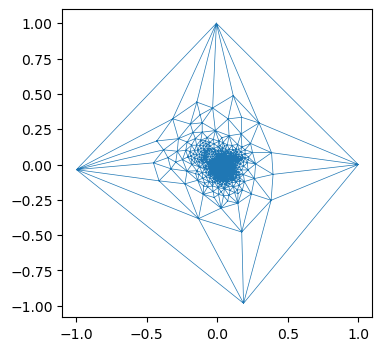

In [ ]:
#| hide
#| notest

fig = plt.figure(figsize=(4,4))

plt.triplot(*uv.T, faces_disk, lw=0.5)
plt.axis("equal")

In [ ]:
#| hide
#| notest

areas = igl.doublearea(mesh.vertices, faces_all)
areas = (areas/areas.mean())
def get_distoration(R):
    """
    Measure area distortion as function of mesh -> plane scale factor.
    """
    coords_sphere = np.vstack([stereographic_plane_to_sphere(R*uv), np.array([0,0,1])])
    areas_sphere = igl.doublearea(coords_sphere, faces_all)
    areas_sphere = np.clip(areas_sphere, 1e-20, 4*np.pi)
    areas_sphere = (areas_sphere/areas_sphere.mean())
    distortion = np.log(areas_sphere/areas)
    return np.abs(distortion).mean()
sol = optimize.minimize_scalar(get_distoration, bounds=(0, 100))

Rs = np.linspace(0.1, 1000, 100)
dists = [get_distoration(R) for R in Rs]

17.134131405697765


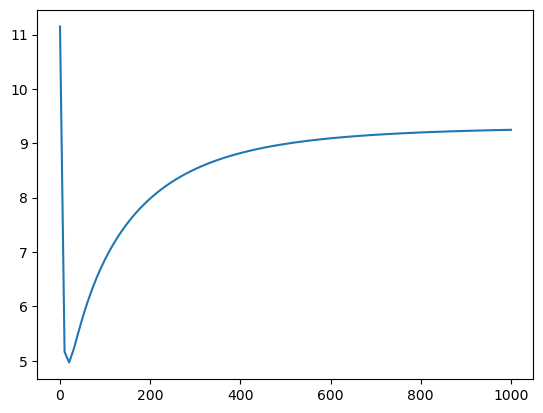

In [ ]:
#| hide
#| notest

Rs = np.linspace(0.1, 1000, 100)
dists = [get_distoration(R) for R in Rs]

plt.plot(Rs, dists)
print(sol.x)

In [ ]:
#| export

def map_to_sphere(mesh, method="harmonic", R_max=100, n_iter_centering=20, alpha=0.5, set_uvs=False):
    """
    Compute a map of mesh to the unit sphere.
    
    First, remove one vertex (the last one), and map the resulting disk-topology
    mesh to the plane using least squares conformal maps. Then map the plane to
    the sphere using stereographic projection.
    
    The conformal map is chosen so that area distortion is as small as possible by
    (a) optimizing over the scale ("radius") of the map to the disk and (b) "centering"
    the map using Algorithm 1 from cs.cmu.edu/~kmcrane/Projects/MobiusRegistration/paper.pdf.
    
    This means the map is canonical up to rotations of the sphere.
    
    Parameters
    ----------
    mesh : tcmesh.ObjMesh
        Mesh. Must be topologically a sphere, and should be triangular.
    method : str, "harmonic", "LSCM"
        Method for computing the map from mesh without the north pole to the plane.
        Recommended: harmonic.
    R_max :  float
        Maximum radius to consider when computing inverse stereographic
        projection. If you get weird results, try a lower value.
    n_iter_centering : int
        Centering algorithm iterations. If 0, no centering is performed
    alpha : float between 0 and 1
        Learning rate. Lower values make the centering algorithm more stable
    Returns
    -------
    vertices_sphere : np.array
        Sphere coordinates. Same shape as mesh.vertices
    """
    if not mesh.is_triangular:
        warnings.warn("Warning: ignoring non-triangular faces", RuntimeWarning)
    # remove "north pole" - by convention, the last vertex in the mesh
    north_pole = mesh.vertices.shape[0]-1
    faces_all = mesh.tris
    tri_mask = (faces_all==north_pole).any(axis=1) 
    faces_disk = faces_all[~tri_mask]
    vertices_disk = mesh.vertices[:-1]
    ## Find the open boundary
    bnd = igl.boundary_loop(faces_disk)
    assert method in ["LSCM", "harmonic"], "Invalid method"
    if method == "LSCM": ## least squares conformal map
        bnd = igl.boundary_loop(faces_disk)
        b = np.array([bnd[0], bnd[int(np.round(len(bnd)/2))]])
        bc = np.array([[0.0, -1.0], [0.0, 1.0]])
        _, uv = igl.lscm(vertices_disk, faces_disk, b, bc)
        uv = uv-uv.mean(axis=0)
    if method == "harmonic": # harmonic map
        bnd_uv = igl.map_vertices_to_circle(vertices_disk, bnd)
        uv = igl.harmonic(vertices_disk, faces_disk, bnd, bnd_uv, 1)
    # map plane to sphere. the scale factor of the map mesh -> plane is arbitrary,
    # so we chose it in a way that minimizes area distortion
    areas = igl.doublearea(mesh.vertices, faces_all)
    areas = (areas/areas.mean())
    def get_distoration(R):
        """
        Measure area distortion as a function of mesh -> plane scale factor.
        """
        coords_sphere = np.vstack([stereographic_plane_to_sphere(R*uv), np.array([0,0,1])])
        areas_sphere = igl.doublearea(coords_sphere, faces_all)
        areas_sphere = np.clip(areas_sphere, 1e-20, 4*np.pi)
        areas_sphere = (areas_sphere/areas_sphere.mean())
        distortion = np.log(areas_sphere/areas)
        return np.abs(distortion).mean()
    sol = optimize.minimize_scalar(get_distoration, bounds=(0, R_max))
    R_opt = sol.x
    vertices_sphere = np.vstack([stereographic_plane_to_sphere(R_opt*uv), np.array([0,0,1])])
    # center map to sphere using Moebius ivnersions
    if n_iter_centering > 0:
        vertices_sphere, _ = center_moebius(mesh.vertices, vertices_sphere, faces_all,
                                            n_iter_centering=n_iter_centering, alpha=alpha)
    if igl.doublearea(vertices_sphere, faces_all).min() <= 0:
        warnings.warn("Warning: some triangle on sphere have 0 or negative area", RuntimeWarning)
        
    return vertices_sphere

In [ ]:
mesh = deepcopy(mesh_final_UV)
coords_sphere = map_to_sphere(mesh, n_iter_centering=10, method="harmonic")
tcmesh.ObjMesh(vertices=coords_sphere, faces=mesh.tris).write_obj("datasets/movie_example/map_to_sphere.obj")


In [ ]:
angles_3d = igl.internal_angles(mesh.vertices, mesh.tris)
angles_sphere = igl.internal_angles(coords_sphere, mesh.tris)

np.nanmean(np.abs(angles_sphere.flatten()-angles_3d.flatten())) # map to sphere is close to conformal/angle-preserving

In [ ]:
#| hide

# Check that the Moebius centering algorithm improves area distortion
mesh = deepcopy(mesh_final_UV)
vertices_sphere_uncentered = map_to_sphere(mesh, n_iter_centering=0, method="harmonic")

coords_sphere_centered, error = center_moebius(mesh.vertices, vertices_sphere_uncentered,
                                               mesh.tris, n_iter_centering=100, alpha=0.5)

areas_3d = igl.doublearea(mesh.vertices, mesh.tris)

areas_sphere = igl.doublearea(vertices_sphere_uncentered, mesh.tris)
distortion = np.log(areas_sphere/areas_3d)
distortion -= distortion.mean()

areas_sphere_centered = igl.doublearea(coords_sphere_centered, mesh.tris)
distortion_centered = np.log(areas_sphere_centered/areas_3d)
distortion_centered -= distortion_centered.mean()

In [ ]:
#| hide

np.abs(distortion).mean(), np.abs(distortion_centered).mean()

(2.883900793812617, 1.294610349934026)

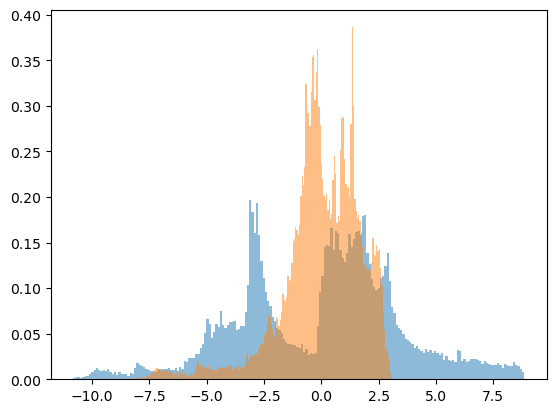

In [ ]:
#| hide

plt.hist(distortion, density=True, bins=200, alpha=0.5);
plt.hist(distortion_centered, density=True, bins=200, alpha=0.5);

### Rotation alignment using `rotation` module

For a map to the sphere, we can compute the amount of area distortion at each point on the sphere. We can then use this "conformal factor" as a signal to rotationally align two maps (from different meshes) to the sphere.

In [ ]:
#| hide

mesh_source = deepcopy(mesh_final_UV)
mesh_target = deepcopy(mesh_source)
coords_sphere_source = map_to_sphere(mesh_source)
rot_mat = stats.special_ortho_group.rvs(3)
coords_sphere_target = coords_sphere_source @ rot_mat.T
print(rot_mat)

[[-0.41209049 -0.11719039  0.90357503]
 [-0.75883921 -0.50476861 -0.41154794]
 [ 0.50432578 -0.85526316  0.11908168]]


In [ ]:
#| hide

# now we need to compute the conformal factor
conformal_factor_source = tcdfg.compute_per_vertex_area_distortion(coords_sphere_source, mesh_source.tris,
                                                                   mesh_source.vertices, mesh_source.tris)
conformal_factor_target = tcdfg.compute_per_vertex_area_distortion(coords_sphere_target, mesh_target.tris,
                                                                   mesh_target.vertices, mesh_target.tris)
# transform to log
signal_source = np.log(conformal_factor_source)
signal_target = np.log(conformal_factor_target)

# and compute the spherical harmonics coefficients
max_l = 10

_, theta_source, phi_source = tcrot.cartesian_to_spherical(coords_sphere_source)
_, theta_target, phi_target = tcrot.cartesian_to_spherical(coords_sphere_target)

weights_source = igl.doublearea(coords_sphere_source, mesh_source.tris)/2
weights_source = igl.average_onto_vertices(coords_sphere_source, mesh_source.tris,
                                           np.stack(3*[weights_source], axis=-1))[:,0]

weights_target = igl.doublearea(coords_sphere_target, mesh_target.tris)/2
weights_target = igl.average_onto_vertices(coords_sphere_target, mesh_target.tris,
                                           np.stack(3*[weights_target], axis=-1))[:,0]

# subtract mean
signal_source -= np.average(signal_source, weights=weights_source)
signal_target -= np.average(signal_target, weights=weights_target)

coeffs_source = tcrot.compute_spherical_harmonics_coeffs(signal_source, phi_source, theta_source, weights_source,
                                                         max_l=max_l)
coeffs_target = tcrot.compute_spherical_harmonics_coeffs(signal_target, phi_target, theta_target, weights_target,
                                                         max_l=max_l)

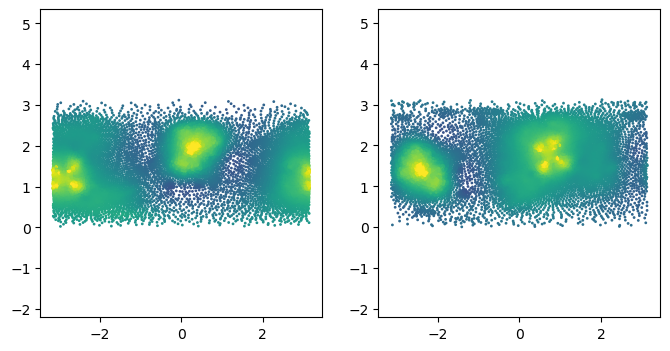

In [ ]:
# this is what the conformal factor (area distortion) looks like plotted vs phi, theta, for an example
# (the same mesh mapped to the sphere, but arbitrarily rotated)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4))

ax1.scatter(phi_source, theta_source, c=signal_source, s=1, vmin=-3, vmax=3)
ax2.scatter(phi_target, theta_target, c=signal_target, s=1, vmin=-3, vmax=3)

ax1.axis("equal");
ax2.axis("equal");

In [ ]:
#| hide
#| notest

# now let's compute the rotation to match them. Looks good!

R_refined, overlap = tcrot.rotational_alignment(coeffs_source, coeffs_target,
                                          max_l=max_l, n_angle=100, n_subdiv_axes=1, maxfev=100,
                                          allow_flip=True)
print(overlap)

0.9999999981999116


In [ ]:
#| export

def rotational_align_sphere(mesh_source, mesh_target, coords_sphere_source, coords_sphere_target,
                            allow_flip=False, max_l=10, n_angle=100, n_subdiv_axes=1, maxfev=100):
    """
    Rotationally align two UV maps to the sphere by the conformal factor.
    
    Computes aligned spherical coordinates. Rotational alignment works by computing
    the conformal factor (how much triangle size changes as it is
    mapped to the sphere) and optimizing over rotations to find the one
    which leads to the best alignment. This works via an expansion in
    spherical harmonics. See tcrot.rotational_alignment
    
    Parameters
    ----------
    mesh_source : tcmesh.ObjMesh
        Mesh. Must be topologically a sphere (potentially with holes),
        and should be triangular.
    mesh_target : tcmesh.ObjMesh
        Mesh. Must be topologically a sphere (potentially with holes),
        and should be triangular.
    coords_sphere_source : np.array or None
        Sphere coordinates for each vertex in the source mesh.
        If None, the UV coordinates are interpreted as angles 2*pi*u=phi,
        2*pi*v=theta.
    coords_sphere_target : np.array or None
        Sphere coordinates for each vertex in the source mesh.
        If None, the UV coordinates are interpreted as angles 2*pi*u=phi,
        2*pi*v=theta.
    allow_flip : bool
        Whether to allow improper rotations with determinant -1. 
    max_l : int
        Maximum angular momentum. If None, the maximum value available in the input
        spherical harmonics is used.
    n_angle : int
        Number of trial rotation angles [0,..., 2*pi]
    n_subdiv_axes : int
        Controls the number of trial rotation axes. Rotation axes are vertices of
        the icosphere which can be subdivided. There will be roughly
        40*4**n_subdiv_axes trial axes. This parameter has the strongest influence
        on the run time.
    maxfev : int
        Number of function evaluations during fine optimization.
    
    Returns
    -------
    coords_sphere_source_rotated : np.array
        Rotationally aligned sphere vertices
    rot_mat : np.array of shape (3,3)
        Rotation matrix
    overlap  : float
        How well the conformal factors overlap. 1 = perfect overlap.
    
    """
    if coords_sphere_source is None:
        coords_sphere_source = spherical_to_cartesian(1, 2*np.pi*mesh_source.texture_vertices[:,1],
                                                      2*np.pi*mesh_source.texture_vertices[:,0])
        tris_sphere_source = mesh_source.texture_tris
    else:
        tris_sphere_source = mesh_source.tris

    if coords_sphere_target is None:
        coords_sphere_target = spherical_to_cartesian(1, 2*np.pi*mesh_target.texture_vertices[:,1],
                                                      2*np.pi*mesh_target.texture_vertices[:,0])
        tris_sphere_target = mesh_target.texture_tris
    else:
        tris_sphere_target = mesh_target.tris

    # compute the conformal factor
    conformal_factor_source = tcdfg.compute_per_vertex_area_distortion(coords_sphere_source, tris_sphere_source,
                                                                       mesh_source.vertices, mesh_source.tris,)
    conformal_factor_target = tcdfg.compute_per_vertex_area_distortion(coords_sphere_target, tris_sphere_target,
                                                                       mesh_target.vertices, mesh_target.tris)
    # transform to log
    signal_source = np.log(conformal_factor_source)
    signal_target = np.log(conformal_factor_target)

    # compute the spherical harmonics coefficients
    max_l = 10
    _, theta_source, phi_source = tcrot.cartesian_to_spherical(coords_sphere_source)
    _, theta_target, phi_target = tcrot.cartesian_to_spherical(coords_sphere_target)
    weights_source = igl.doublearea(coords_sphere_source, tris_sphere_source)/2
    weights_source = igl.average_onto_vertices(coords_sphere_source, tris_sphere_source,
                                               np.stack(3*[weights_source], axis=-1))[:,0]
    weights_target = igl.doublearea(coords_sphere_target, tris_sphere_target)/2
    weights_target = igl.average_onto_vertices(coords_sphere_target, tris_sphere_target,
                                               np.stack(3*[weights_target], axis=-1))[:,0]
    # subtract mean
    signal_source -= np.average(signal_source, weights=weights_source)
    signal_target -= np.average(signal_target, weights=weights_target)
    coeffs_source = tcrot.compute_spherical_harmonics_coeffs(signal_source, phi_source, theta_source,
                                                             weights_source, max_l=max_l)
    coeffs_target = tcrot.compute_spherical_harmonics_coeffs(signal_target, phi_target, theta_target,
                                                             weights_target, max_l=max_l)
        
    # compute the rotation to match them.
    R_refined, overlap = tcrot.rotational_alignment(coeffs_source, coeffs_target, max_l=max_l,
                                                    n_angle=n_angle, n_subdiv_axes=n_subdiv_axes, maxfev=maxfev,
                                                    allow_flip=allow_flip)

    return coords_sphere_source @ R_refined.T, R_refined, overlap

In [ ]:
# first test case: same mesh, but map to the sphere rotatated

mesh_source = deepcopy(mesh_final_UV)
mesh_target = deepcopy(mesh_final_UV)

coords_sphere_source = map_to_sphere(mesh_source)
rot_mat = stats.special_ortho_group.rvs(3)
coords_sphere_target = coords_sphere_source @ rot_mat.T

In [ ]:
transformed, R, overlap = rotational_align_sphere(mesh_source, mesh_target,
                                                  coords_sphere_source, coords_sphere_target,
                                                  allow_flip=False, max_l=10, n_angle=100, n_subdiv_axes=1,
                                                  maxfev=100)

np.linalg.norm(R-rot_mat), overlap

(0.0004874609816821069, 0.9999997693026267)

In [ ]:
# second test case: meshes for two frames of a movie

mesh_source = deepcopy(mesh_2) # mesh_final_UV
mesh_target = deepcopy(mesh_1) # mesh_initial_UV

coords_sphere_source = map_to_sphere(mesh_source)
coords_sphere_target = map_to_sphere(mesh_target)

In [ ]:
transformed, R, overlap = rotational_align_sphere(mesh_source, mesh_target,
                                                  coords_sphere_source, coords_sphere_target,
                                                  allow_flip=False, max_l=10, n_angle=100, n_subdiv_axes=1,
                                                  maxfev=100)
overlap

0.9908056596783977

### Interpolation

Now that we have (a) mapped both meshes to the sphere, (b) minized distortion via Moebius centering, and (c) rotationally aligned the two maps via spherical harmonics, we can interpolate the coordinates of mesh B onto mesh A.

In [ ]:
#| export

def wrap_coords_via_sphere(mesh_source, mesh_target, coords_sphere_source=None, coords_sphere_target=None,
                           method="harmonic", n_iter_centering=10, alpha=0.5,
                           align=True, allow_flip=False, max_l=10, n_angle=100, n_subdiv_axes=1, maxfev=100):
    """
    Map 3d coordinates of source mesh to target mesh via a sphere parametrization.
    
    Sphere parametrizations can be provided or computed on the fly using the least-area
    distorting conformal map to the sphere (see map_to_sphere). If desired, the two
    parametrizations are also aligned with respect to 3d rotations using mesh shape,
    using spherical harmonics. See rotational_align_sphere for details.
    
    Parameters
    ----------
    mesh_source : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    mesh_target : tcmesh.ObjMesh
        Mesh. Must be topologically a disk (potentially with holes),
        and should be triangular.
    coords_sphere_source : np.array or None
        Sphere coordinates for each vertex in the source mesh. Optional.
        If None, computed via map_to_sphere.
    coords_sphere_target : np.array or None
        Sphere coordinates for each vertex in the target mesh. Optional.
        If None, computed via map_to_sphere.
    method : str, "harmonic" or "LSCM"
        Method for comuting the map from sphere without north pole to plane
    n_iter_centering : int
        Centering algorithm iterations for computing map to the sphere. If 0, no centering is performed
    alpha : float between 0 and 1
        Learning rate for computing map to the sphere. Lower values make the centering algorithm more stable.
    align : bool, default True
        Whether to rotationally align the parametrizations. If False, they are used as-is.
    allow_flip : bool
        Whether to allow improper rotations with determinant -1 for rotational alignment.
    max_l : int
        Maximum angular momentum. If None, the maximum value available in the input
        spherical harmonics is used.
    n_angle : int
        Number of trial rotation angles [0,..., 2*pi]
    n_subdiv_axes : int
        Controls the number of trial rotation axes. Rotation axes are vertices of
        the icosphere which can be subdivided. There will be roughly
        40*4**n_subdiv_axes trial axes. This parameter has the strongest influence
        on the run time.
    maxfev : int
        Number of function evaluations during fine optimization for rotational alignment.

    Returns
    -------
    new_coords : np.array
        New 3d vertex coordinates for mesh_source, lying on the surface
        defined by mesh_target
    overlap : np.array
        Overlap of conformal factor (area distortion) on sphere of the two meshes. Only returned if align is True.
        1 indicates perfect overlap.
    """
    # compute harmonic map to disk
    if coords_sphere_source is None:
        coords_sphere_source = map_to_sphere(mesh_source, n_iter_centering=n_iter_centering, alpha=alpha,
                                             set_uvs=False, method=method)
    if coords_sphere_target is None:
        coords_sphere_target = map_to_sphere(mesh_target, n_iter_centering=n_iter_centering, alpha=alpha,
                                             set_uvs=False, method=method)
    # rotational alignment of parametrizations
    if align:
        coords_sphere_source_aligned, R, overlap = rotational_align_sphere(mesh_source, mesh_target,
                                                coords_sphere_source, coords_sphere_target,
                                                allow_flip=allow_flip, max_l=max_l,
                                                n_angle=n_angle, n_subdiv_axes=n_subdiv_axes, maxfev=maxfev)
    else:
        coords_sphere_source_aligned = coords_sphere_source
    # copy over 3d coordinates 
    new_coords = tcinterp.interpolate_barycentric(coords_sphere_source_aligned,
                                                  coords_sphere_target,
                                                  mesh_target.tris, mesh_target.vertices, distance_threshold=np.inf)
    if align:
        return new_coords, overlap
    return new_coords

In [ ]:
#mesh_source = deepcopy(mesh_1)
#mesh_target = deepcopy(mesh_1)

#mesh_source = deepcopy(mesh_1)
#mesh_target = deepcopy(mesh_2)

mesh_source = deepcopy(mesh_final_UV)
mesh_target = deepcopy(mesh_initial_UV)

In [ ]:
mesh_source.vertices[-1], mesh_target.vertices[-1]

(array([ 398.323151,  570.099976, -977.260376]),
 array([457.797119, 947.645935, 547.180786]))

In [ ]:
new_coords, overlap  = wrap_coords_via_sphere(mesh_source, mesh_target,
                                              coords_sphere_source=None, coords_sphere_target=None,
                                              n_iter_centering=20, alpha=0.5, align=True,
                                              method="harmonic",
                                              allow_flip=True, max_l=10, n_angle=100, n_subdiv_axes=1, maxfev=200)

In [ ]:
overlap # mesh_final_UV, mesh_initial_UV 0.918 with harmonic map, 0.919 harmonic-free-boundary

0.9181743310396068

In [ ]:
mesh_wrapped = deepcopy(mesh_source)
mesh_wrapped.vertices = new_coords

In [ ]:
mesh_source.write_obj("datasets/movie_example/source_moebius.obj")
mesh_target.write_obj("datasets/movie_example/target_moebius.obj")
mesh_wrapped.write_obj("datasets/movie_example/wrapped_moebius.obj")

## Stuff that did not work out well

### Non-rigid ICP

Try it out first using trimesh, then do myself to avoid dependency. Use `trimesh.registration.nricp_sumner`


-> No good, takes forever and my laptop runs out of memory. Also lots of parameters to tune whose meaning I don't know.

### Laplace Beltrami descriptors

Idea - compute the eigenfunctions $\phi_i$ of the Laplace operator $\Delta$ on the surface, and the embed each point $p$ on the surface as $p\mapsto \phi_i(p)/\sqrt{\lambda_i}$. 

Not suitable - the spectral shapes of the midgut example mesh become extremely degenerate.

See https://www.cs.jhu.edu/~misha/ReadingSeminar/Papers/Rustamov07.pdf, https://web.archive.org/web/20100626223753id_/http://www.cs.jhu.edu/~misha/Fall07/Notes/Rustamov07.pdf

In [ ]:
#| hide
#| notest

mesh = mesh_initial_UV
laplacian = igl.cotmatrix(mesh.vertices, mesh.tris)
mass = igl.massmatrix(mesh.vertices, mesh.tris)

In [ ]:
#| hide
#| notest

eigen_vals, eigen_vecs = sparse.linalg.eigsh(-laplacian, M=mass, k=10, ncv=100, which="SM")

eigen_vals, eigen_vecs = (eigen_vals[1:], eigen_vecs[:, 1:])

CPU times: user 14.1 s, sys: 1.92 s, total: 16 s
Wall time: 4.73 s


In [ ]:
#| hide
#| notest

eigen_vals = eigen_vals / eigen_vals[0]
eigen_vecs = eigen_vecs / np.abs(eigen_vecs).mean()

<matplotlib.collections.PolyCollection>

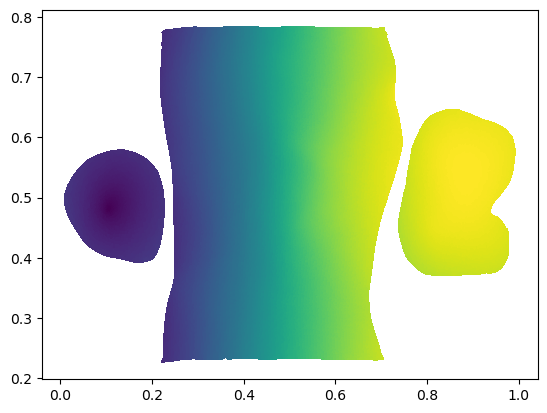

In [ ]:
#| hide
#| notest

matched_vertex_inds = mesh.get_vertex_to_texture_vertex_indices()
plt.tripcolor(*mesh.texture_vertices.T, mesh.texture_tris, eigen_vecs[matched_vertex_inds,0])

In [ ]:
#| hide
#| notest

mesh_spectral = deepcopy(mesh)
mesh_spectral.vertices = eigen_vecs[:,:3] *np.array([11,1,1]) / np.sqrt(eigen_vals[:3])
mesh_spectral.write_obj("datasets/movie_example/spectral_final.obj")

### Functional mapping

https://people.csail.mit.edu/jsolomon/assets/fmaps.pdf - uses Laplace Beltrami descriptors. There appears to be an existing implementation in python: https://github.com/RobinMagnet/pyFM. Let's try out https://github.com/RobinMagnet/pyFM/blob/master/examples/mesh_and_matching/basic_functions.ipynb

It does not work that well. Ok for matching from mapping timepoints 1->2, bad for 1->20, or 20->30. I get "patchy correspondences": the map mesh A -> mesh B is not continuous and tears up mesh A into multiple patches that are stitched together in somewhat random order on mesh B.  Also kinda slow.

As Dillon pointed out, shape descriptors of Laplace-Beltrami kind fundamentally use _metric_ information. Laplace Beltrami is equivalent to a metric. Good for isometric deformations, like joint movements, bad for non-isometric, which is often the case for us.

So in principle, this is a nice method, but not quite what we need.

In [ ]:
#| hide
#| notest

#from pyFM.mesh import TriMesh
#from pyFM.functional import FunctionalMapping
#import meshplot as mp

In [ ]:
#| hide
#| notest

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

In [ ]:
#| hide
#| notest

meshes_dict = {i: tcmesh.read_other_formats_without_uv(f"movie_example/meshes/mesh_{str(i).zfill(2)}.ply")
               for i in tqdm(range(1, 32))}
mesh1 = TriMesh(meshes_dict[1].vertices, meshes_dict[1].tris)
mesh2 = TriMesh(meshes_dict[5].vertices, meshes_dict[5].tris)

In [ ]:
#| hide
#| notest

# distance computation using heat geodesic  -replace potpourri backend by igl.heat_geodesic
# or igl.exact_geodesic
dists = mesh1.geod_from(1000, robust=True)

mesh1.process(k=100, intrinsic=True, verbose=True);
mesh2.process(k=100, intrinsic=True, verbose=True);

In [ ]:
#| hide
#| notest

# load data to compute a functional map

t0 = 20
t1 = 30

mesh1 = TriMesh(meshes_dict[t0].vertices, meshes_dict[t0].tris)
mesh2 = TriMesh(meshes_dict[t1].vertices, meshes_dict[t1].tris)

In [ ]:
#| hide
#| notest

# compute descriptors

process_params = {
    'n_ev': (35,35),  # Number of eigenvalues on source and Target. - also no improvement
    'subsample_step': 5,  # In order not to use too many descriptors. makes no big difference
    'descr_type': 'WKS',  # WKS or HKS - makes no big difference
}

model = FunctionalMapping(mesh1, mesh2)
model.preprocess(**process_params,verbose=True);


Computing Laplacian spectrum
Computing 200 eigenvectors
	Done in 12.41 s
Computing 200 eigenvectors
	Done in 27.69 s

Computing descriptors
	Normalizing descriptors

	20 out of 100 possible descriptors kept


In [ ]:
#| hide
#| notest

# Fitting the transformation model

fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 1e-2}


model.fit(**fit_params, verbose=True)

Computing commutativity operators
Computing orientation operators
	Scaling LBO commutativity weight by 3.9e+04
	Scaling orientation preservation weight by 1.2e+14

Optimization :
	35 Ev on source - 35 Ev on Target
	Using 20 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-02
		Orientation preservation :1.2e+12

	Task : CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL, funcall : 173, nit : 162, warnflag : 0
	Done in 0.34 seconds


In [ ]:
#| hide
#| notest

p2p_21 = model.get_p2p(n_jobs=1)
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot(mesh1,mesh2,cmap1,cmap2)

In [ ]:
#| hide
#| notest

# refine map - improves it somewhat

model.icp_refine(verbose=True)
p2p_21_icp = model.get_p2p()


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#| hide
#| notest

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_icp]
double_plot(mesh1,mesh2,cmap1,cmap2)

In [ ]:
#| hide
#| notest

model.change_FM_type('classic') # We refine the first computed map, not the icp-refined one
model.zoomout_refine(nit=15, step = 1, verbose=True)
print(model.FM.shape)
p2p_21_zo = model.get_p2p()

  0%|          | 0/15 [00:00<?, ?it/s]

(50, 50)


In [ ]:
#| hide
#| notest

cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_zo]
double_plot(mesh1,mesh2,cmap1,cmap2)